### Importing Libraries

In [ ]:
import pandas as pd # for reading captions files
import matplotlib.pyplot as plt # To show graphs
import matplotlib.image as mpimg # For working with images
import os  # interacting with system
from collections import Counter # Counter - Used in Looping
import spacy  # Processing Captions
import torch  # PyTorch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset  # Loading and preparing Data
import torchvision.transforms as T  # for transforming(converting) data
from PIL import Image # preprocessing images
import numpy as np  # - For Numerical operations on the Data
import torch.nn as nn  # Neural Network
import torch.nn.functional as F  # Accesing Functional Layes
import torch.optim as optim  # Accessing Optimizer for buillding model architecture
import torchvision.models as models    # Creating Model Architecture


### Exploring Data

In [ ]:
data_location =  "/content/drive/MyDrive/Image Captioning System" # Dataset location - Flickr Dataset
model_save_path = '/content/drive/MyDrive/Image Captioning System/my_final_model.pt'

In [ ]:
caption_file = data_location + '/captions.txt'  # locating the file
df = pd.read_csv(caption_file)  # reading captions file

In [ ]:
data_idx = 3  # image to show for example
image_path = data_location+"/Images/"+df.iloc[data_idx,0] # locating image
img=mpimg.imread(image_path) # reading image
plt.imshow(img) # showing image
plt.show() # showing image graph

# For showing five captions of a image 
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

#### Custom Data

In [ ]:
#using spacy for the better text tokenization 
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)] # tokeniz the caption

In [ ]:
# Define a class called Vocabulary
class Vocabulary:

    # Define the constructor method for the class
    def __init__(self,freq_threshold):
        
        # Initialize a dictionary called itos with special tokens at specific indices
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        # Initialize a dictionary called stoi with keys and values of itos inverted
        self.stoi = {v:k for k,v in self.itos.items()}
        
        # Initialize a dictionary called stoi with keys and values of itos inverted
        self.freq_threshold = freq_threshold
        
    # Define a method to get the length of the vocabulary
    def __len__(self): return len(self.itos)
    
    # Define a static method to tokenize text using spaCy tokenizer
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    # Define a method to build the vocabulary from a list of sentences
    def build_vocab(self, sentence_list):

        # Initialize a counter to keep track of word frequencies
        frequencies = Counter()
        idx = 4
        
        # Loop through each sentence in the list of sentences
        for sentence in sentence_list:

            # Tokenize the sentence using the tokenize method defined earlier
            for word in self.tokenize(sentence):
                # Increment the frequency of the current word
                frequencies[word] += 1
                
                # If the frequency of the current word reaches the frequency threshold,
                # add it to the vocabulary and increment the index
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    # Define a method to convert a text into a list of numerical tokens based on the vocabular
    def numericalize(self,text):
      
        # Tokenize the text using the tokenize method defined earlier
        tokenized_text = self.tokenize(text)

        # Convert each token into its corresponding index in the vocabulary (or <UNK> if it's not in the vocabulary)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]   

In [ ]:
#Testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

In [ ]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):

        # Initialize dataset attributes
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        # Extract image names and captions from dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        # Create vocabulary object and build vocab from captions
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    # Return the length of the dataset
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        # Retrieve the caption and image name for the given index
        caption = self.captions[idx]
        img_name = self.imgs[idx]

        # Construct the path to the image file and load it
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        # Apply any specified image transforms
        if self.transform is not None:
            img = self.transform(img)
        
        # Convert the caption to a numericalized vector using the vocabulary
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]] # Start-of-sentence token
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]] # End-of-sentence token
        
        # Return the image tensor and caption tensor as a tuple
        return img, torch.tensor(caption_vec)

In [ ]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    # Normalize the image tensor
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    # Convert the tensor to numpy array and change the dimension order
    img = img.numpy().transpose((1, 2, 0))
    
    # Show the image using matplotlib
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

In [ ]:
#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),        # Resizing the images              
    T.RandomCrop(224),    # Random croping for the image - Data Augmentation            
    T.ToTensor(),         # Converting into Tensor -         
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))  # Normalizing the image ternsor - for faster training
])


dataset =  FlickrDataset(
    root_dir = data_location+"/Images", # Images Data Location
    captions_file = data_location+"/captions.txt",  # Captions data location
    transform=transforms  # Applying transfromations
)



img, caps = dataset[34] # One Example
show_image(img,"Image")  # Showing the example
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])  # Tokenizing the example caption

NameError: ignored

In [ ]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):

        # Initialize the Collate object with pad index and batch first parameters
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        # Extract images and targets (captions) from the batch
        imgs = [item[0].unsqueeze(0) for item in batch]
        # Stack the images along the batch dimension
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        # Pad the targets (captions) with the pad index
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        # Return the padded targets and images as tensors
        return imgs,targets

In [ ]:
BATCH_SIZE = 4 # Batch Numner for DataLoader
NUM_WORKER = 1  # Number of workers for DataLoader

# Get the padding index for vocabulary
pad_idx = dataset.vocab.stoi["<PAD>"]

# Create a DataLoader object with dataset, batch size, number of workers, shuffle and collate_fn arguments
data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

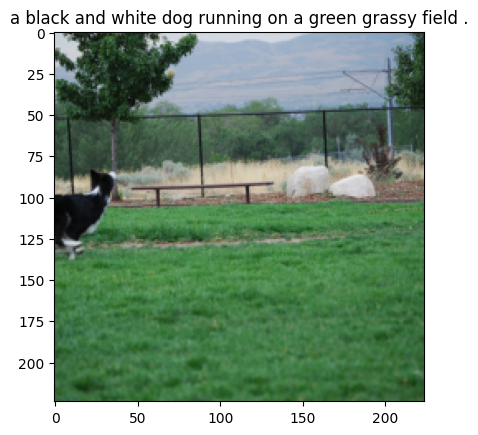

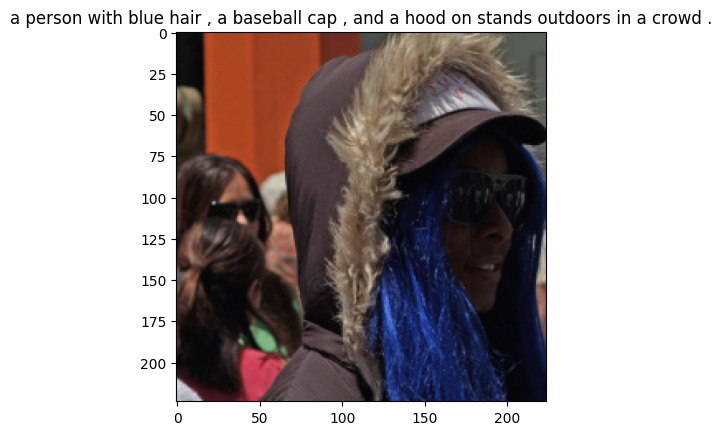

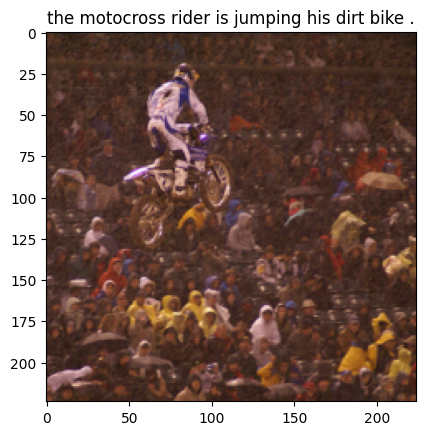

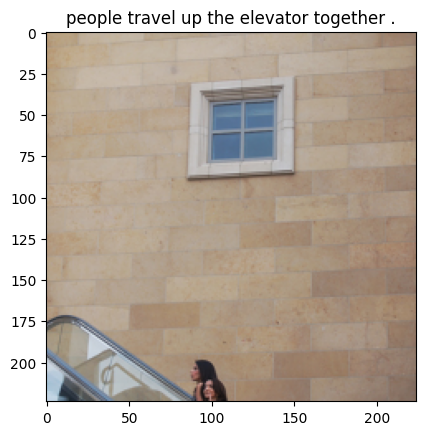

In [ ]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

### Model

In [ ]:
# Checking what is available  - CPU or GPU(cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Defining the EncoderCNN class as a subclass of nn.Module
class EncoderCNN(nn.Module):
    def __init__(self):
        # Initializing the superclass(nn.Module)
        super(EncoderCNN, self).__init__()
        
        # Initializing a pre-trained ResNet50 model
        resnet = models.resnet50(pretrained=True)
        
        # Freezing the weights of the ResNet50 model
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # Extracting all layers of the ResNet50 model except the last two layers
        modules = list(resnet.children())[:-2]
        
        # Defining a Sequential model with the extracted modules
        self.resnet = nn.Sequential(*modules)
        
    # Defining the forward pass of the EncoderCNN class
    def forward(self, images):
        # Forward propagating the images through the ResNet50 model
        features = self.resnet(images)
        
        # Permuting the dimensions of the features tensor
        features = features.permute(0, 2, 3, 1)
        
        # Flattening the features tensor
        features = features.view(features.size(0), -1, features.size(-1))
        
        # Returning the final features tensor
        return features

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        # initialize attention layer parameters
        self.attention_dim = attention_dim
        self.W = nn.Linear(decoder_dim, attention_dim) # linear layer to transform decoder hidden state
        self.U = nn.Linear(encoder_dim, attention_dim) # linear layer to transform encoder features
        self.A = nn.Linear(attention_dim, 1)           # linear layer to get attention scores
        
    def forward(self, features, hidden_state):
        # transform the encoder features and decoder hidden state
        u_hs = self.U(features)    # shape: (batch_size, num_pixels, attention_dim)
        w_ah = self.W(hidden_state) # shape: (batch_size, attention_dim)
        
        # calculate attention scores and weights
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) # shape: (batch_size, num_pixels, attention_dim)
        attention_scores = self.A(combined_states) # shape: (batch_size, num_pixels, 1)
        attention_scores = attention_scores.squeeze(2) # shape: (batch_size, num_pixels)
        
        # normalize the attention scores across the image pixels
        alpha = F.softmax(attention_scores,dim=1) # shape: (batch_size, num_pixels)
        
        # calculate the weighted average of the encoder features using the attention weights
        attention_weights = features * alpha.unsqueeze(2) # shape: (batch_size, num_pixels, encoder_dim)
        attention_weights = attention_weights.sum(dim=1)  # shape: (batch_size, encoder_dim)
        
        # return the attention scores and the weighted average of the encoder features
        return alpha, attention_weights


In [ ]:
# Attention Decoder module to generate captions
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        # generate embeddings for words
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        # features representation
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        # linear layer that outputs one-hot vector of predicted word
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    # inputs are feature representation and captions (vectors)    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        # predicted captions in form of one-hot vectors
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
        
        # feed in the input for each time instance along with context vectors
        for s in range(seq_length):
            # first, pass the features and decoder hidden state
            alpha,context = self.attention(features, h)
            
            # lstm input are embeddings repr words and context vectors
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            
            # hidden state for next time instance
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # pass through dropout layer
            output = self.fcn(self.drop(h))
            
            # get the prediction and weights
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=50,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        # store the weights
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        # captions generated 
        captions = []
        
        for i in range(max_len):
            # take encoder output and compute the current attention
            alpha,context = self.attention(features, h)
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            # conatenation of current state embeddings and context vectors
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    # features from encoder CNN 
    def init_hidden_state(self, encoder_out):
        batch_size = encoder_out.size(0)
        h = torch.zeros(batch_size, self.decoder_dim).to(encoder_out.device)
        c = torch.zeros(batch_size, self.decoder_dim).to(encoder_out.device)
        return h, c

In [ ]:
# Seq2Seq model to generate image captions

class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        # encoder doesn't need any params to specify
        self.encoder = EncoderCNN()
        # decoder params need to be specified
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
    
    def forward(self, images, captions):
        # pass the images through encoder to ger feature representations
        features = self.encoder(images)
        # features and captions are passed to decoder
        outputs = self.decoder(features, captions)
        return outputs

#### Hyperparameters

In [ ]:
embed_size=500  # size of the word embedding for the vocabulary
vocab_size = len(dataset.vocab)  # Getting the vocab length
attention_dim=256  # Dimension size of attention mechanism
encoder_dim=2048 # dimensions of encoder
decoder_dim=512  # dimensions of decoder
learning_rate = 3e-4 # learning rate

#### Training 

In [ ]:
# Seq2Seq model initialization

model = EncoderDecoder(
    embed_size=500,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]) # loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

In [ ]:
# # helper function to save the model
# def save_model(model,num_epochs):
#     # Model data to keep
#     model_state = {
#         'num_epochs':num_epochs,
#         'embed_size':embed_size,
#         'vocab_size':len(dataset.vocab),
#         'attention_dim':attention_dim,
#         'encoder_dim':encoder_dim,
#         'decoder_dim':decoder_dim,
#         'state_dict':model.state_dict()
#     }

#     torch.save(model_state,'attention_model_state.pth')  # Saving model

Epoch: 1 Batch: 1000 loss: 4.05747
Epoch: 1 Batch: 2000 loss: 3.20559
Epoch: 1 Batch: 3000 loss: 2.94323
Epoch: 1 Batch: 4000 loss: 3.26862
Epoch: 1 Batch: 5000 loss: 3.52611
Epoch: 1 Batch: 6000 loss: 2.98274
Epoch: 1 Batch: 7000 loss: 3.23900
Epoch: 1 Batch: 8000 loss: 2.87771
Epoch: 1 Batch: 9000 loss: 3.30527
Epoch: 1 Batch: 10000 loss: 3.28623


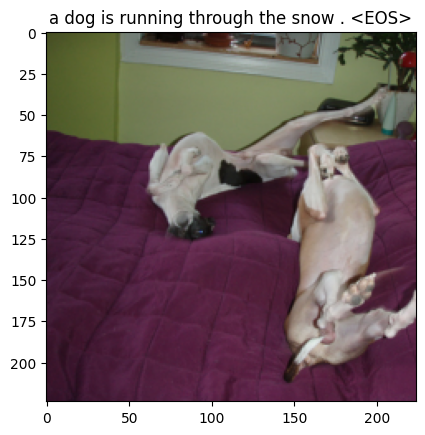

In [ ]:
num_epochs = 1 # How many time to run
print_every = 1000 

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} Batch: {} loss: {:.5f}".format(epoch, idx+1, loss.item()))
        
    #generate the caption and display it
    model.eval()
    with torch.no_grad():
        dataiter = iter(data_loader)
        img,_ = next(dataiter)
        features = model.encoder(img[0:1].to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(img[0],title=caption)

    model.train()

    #save the latest model after every epoch
    # save_model(model,epoch)
    torch.save(model, '/content/model/model_final.pt')

In [ ]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [ ]:
# ! cp '/content/model/model_final.pt' '/content/drive/MyDrive/Image Captioning System'

In [ ]:
# model_path = '/content/drive/MyDrive/Image Captioning System/attention_model_state.pth'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# device

'cpu'

In [ ]:
new_model = torch.load('/content/drive/MyDrive/Image Captioning System/model_final.pt',map_location=device)

In [ ]:
from PIL import Image

In [ ]:
img = Image.open('/content/photo-1438761681033-6461ffad8d80.jpg')

In [ ]:
transforms = T.Compose([
    T.Resize(226),        # Resizing the images              
    T.RandomCrop(224),    # Random croping for the image - Data Augmentation            
    T.ToTensor(),         # Converting into Tensor -         
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))  # Normalizing the image ternsor - for faster training
])


In [ ]:
img = transforms(img)
img = img.unsqueeze(0)


In [ ]:
new_model.eval()
with torch.no_grad():
    output = new_model(img)
    

TypeError: ignored

In [ ]:
# new_model.eval()
# features = model.encoder(img[0:1].to(device))
# caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
# caption = ' '.join(caps)

In [ ]:
# caption[]

'f'